In [13]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy.linalg import eigh
import qutip as qt
import sympy as sym
from joblib import Parallel, delayed, cpu_count

%matplotlib ipympl
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})

In [14]:
nH   = 1e-9
fF   = 1e-15
GHz  = 1e9
h    = 6.626e-34
e0   = 1.602e-19
Φ_0 = h/(2*e0)

In [15]:
C, CJ, Csh, Lq, Lr, Δ, EJ = (
    sq_ext.get_experimental_parameters('qubit_2', return_effective=False))
CR, CF, LF, LR, EJ, Δ, ω_r = (
    sq_ext.get_experimental_parameters('qubit_2', return_effective=True))
C_prime, CJ_prime, Csh_prime, Lq_prime, Lr_prime, Δ_prime, EJ_prime = (
    sq_ext.get_experimental_parameters('qubit_2', return_effective=False))
CR_prime, CF_prime, LF_prime, LR_prime, EJ_prime, Δ_prime, ω_r_prime = (
    sq_ext.get_experimental_parameters('qubit_2', return_effective=True))

LC = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)[2]
LC_prime = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq_prime , Lr_prime , Δ_prime )[2]

In [4]:
nmax_r = 10
nmax_f = 10
only_inner = False
compensate_extra_cap = False
only_renormalization = False
n_eig = 6
φ_ext = 0.5
φ_ext_prime = 0.5

## Full circuit effective Hamiltonian

## Qubit-Qubit effective Hamiltonian

In [10]:
n_eig  = 5
n_plot = 20
CC_values = np.linspace(1e-4,1e1)

N_elements = 2
basis_states = [(0,0), (1,0), (0,1), (1,1)]
max_excitations_mediating_states=4
mediating_states = sq_ext.generate_mediating_states(N_elements, basis_states, max_excitations_mediating_states)
labels_low = [f'({i},{j})' for i, j in basis_states]
labels_high = [f'({i},{j})' for i, j in mediating_states]

n_eig_extra_low = 2

In [11]:
Pauli_p1 = []
Pauli_p2 = []
Pauli_SWT = []
ω_f_0      = np.zeros(len(CC_values))
ω_r_0      = np.zeros(len(CC_values))
g_r_limit  = np.zeros(len(CC_values))
g_fq_limit = np.zeros(len(CC_values))
g_xx_pert  = np.zeros(len(CC_values), dtype='complex')
g_zz_pert  = np.zeros(len(CC_values), dtype='complex')
g_yy_pert  = np.zeros(len(CC_values), dtype='complex')
X          = np.zeros(len(CC_values), dtype='complex')
E_low_vs_Δ= np.zeros([len(CC_values), 4])

for i, CC in enumerate(CC_values):
    C_mat_qubit_C_qubit = sq_ext.C_mat_qubit_C_qubit(CC, CR, CF, CR_prime, CF_prime, only_inner, compensate_extra_cap,
                                                     only_renormalization)
    C_inv_qubit_C_qubit = np.linalg.inv(C_mat_qubit_C_qubit)
    
    CF_tilde = C_inv_qubit_C_qubit[0, 0] ** -1
    CR_tilde = C_inv_qubit_C_qubit[1, 1] ** -1
    CF_prime_tilde = C_inv_qubit_C_qubit[2, 2] ** -1
    CR_prime_tilde = C_inv_qubit_C_qubit[3, 3] ** -1
    
    fluxonium = sq_ext.sq_fluxonium(C_F_eff=CF_tilde, L_F_eff=LF, Δ=Δ, EJ=EJ, nmax_f=nmax_f, φ_ext=φ_ext)
    resonator = sq_ext.sq_resonator(C_R_eff=CR_tilde, L_R_eff=LR, Δ=Δ, EJ=EJ, nmax_r=nmax_r)
    fluxonium_prime = sq_ext.sq_fluxonium(C_F_eff=CF_prime_tilde, L_F_eff=LF_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_f=nmax_f,
                                          φ_ext=φ_ext_prime)
    resonator_prime = sq_ext.sq_resonator(C_R_eff=CR_prime_tilde, L_R_eff=LR_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_r=nmax_r)
    
    circuits = [fluxonium, resonator, fluxonium_prime, resonator_prime]
    LCs = [LC, LC_prime]

    H_0, H = sq_ext.hamiltonian_fluxonium_C_fluxonium(C_inv_qubit_C_qubit[[0,2],:][:,[0,2]], [circuits[0],circuits[2]], nmax_f=nmax_f, return_H_0=True)

    H1 = fluxonium.hamiltonian()
    H2 = fluxonium_prime.hamiltonian()

    ψ0_1 = sq_ext.diag(H1, n_eig, solver='numpy', real=True)[1]
    ψ0_2 = sq_ext.diag(H2, n_eig, solver='numpy', real=True)[1]

    ψ_0_low  = [qt.tensor(qt.Qobj(ψ0_1[:, i]), qt.Qobj(ψ0_2[:, j])) for i, j in basis_states]
    ψ_0_high = [qt.tensor(qt.Qobj(ψ0_1[:, i]), qt.Qobj(ψ0_2[:, j])) for i, j in mediating_states]

    H_eff_p1 = sq_ext.H_eff_p1_large(ψ_0_low, H=H, real=True, remove_ground=True)

    V = H - H_0

    E_0_ψ_0_low = [np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0, 0]) / 2 / np.pi / GHz for ψ_0_i in ψ_0_low]
    E_0_ψ_0_high = [np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0, 0]) / 2 / np.pi / GHz for ψ_0_i in ψ_0_high]

    H_eff_p2, H_eff_p2_decomposed = sq_ext.H_eff_p2_decomposed(ψ_0_low, ψ_0_high, E_0_ψ_0_low, E_0_ψ_0_high, V,
                                                               remove_ground=True)

    E_0 = sq_ext.diag(H_0, n_eig=len(ψ_0_low) + n_eig_extra_low, out='GHz', solver='scipy')[0]
    E, ψ = sq_ext.diag(H, n_eig=len(ψ_0_low) + n_eig_extra_low, out='GHz', solver='Qutip', qObj=True)
    subspace_indices = sq_ext.find_close_indices(E_0_ψ_0_low, E_0)
    ψ_low = ψ[subspace_indices]
    E_low = E[subspace_indices]
    E_low_vs_Δ[i] = E_low

    H_eff_SWT = sq_ext.H_eff_SWT_large(ψ_0_low, ψ_low, E_low, remove_ground=True)

    Pauli_p1.append(sq_ext.decomposition_in_pauli_4x4(H_eff_p1, print_pretty=False))
    Pauli_p2.append(sq_ext.decomposition_in_pauli_4x4(H_eff_p1 + H_eff_p2, print_pretty=False))
    Pauli_SWT.append(sq_ext.decomposition_in_pauli_4x4(H_eff_SWT, print_pretty=False))


Pauli_p1 = np.array(Pauli_p1)
Pauli_p2 = np.array(Pauli_p2)
Pauli_SWT = np.array(Pauli_SWT)

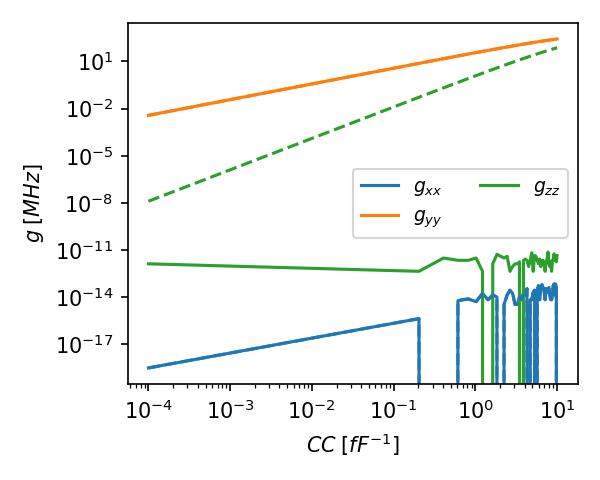

In [17]:
fig, ax1 = plt.subplots(figsize =np.array([5,4])*0.8, dpi=150)
linestyles = ['-', '--','-' ]
colors = figs.generate_colors_from_colormap(10, 'tab10')
set_label  = True


for i, Pauli in enumerate([Pauli_p1, Pauli_p2, Pauli_SWT]):
    # if i==0 or i==2:
    # if i==0 or i==1:
    if i ==2:
        continue

    σxσx = np.abs(Pauli[:, 1,1])
    σyσy = np.abs(Pauli[:, 2,2])
    σzσz = np.abs(Pauli[:, 3,3])
    ωf = np.abs(Pauli[:, 0,-1])
    ωr = np.abs(Pauli[:, -1,0])

    ax1.plot(CC_values, σxσx * 1e3, color = colors[0], linestyle=linestyles[i], label = r'$g_{xx}$')
    ax1.plot(CC_values, σyσy * 1e3, color = colors[1], linestyle=linestyles[i], label = r'$g_{yy}$')
    ax1.plot(CC_values, σzσz * 1e3, color = colors[2], linestyle=linestyles[i], label = r'$g_{zz}$')

    if set_label:
        set_label =False
        ax1.legend(ncol=2, fontsize=9)

ax1.set_yscale('log')
ax1.set_xscale('log')
# ax1.set_ylim([1e-3,1e4])
# ax1.set_xlim([1e-7,7e-3])
ax1.set_ylabel('$g \; [MHz]$')
ax1.set_xlabel('$CC\; [fF^{-1}]$')

# fig.suptitle(r' --- P1 $\quad$ - - P2 $\quad$ $\cdots$ SWT')
fig.tight_layout()
# figs.export('g_H_eff_vs_Lc.pdf', fig)
fig.show()